# Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from IPython.display import HTML, IFrame, FileLink
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
print("Setup Complete")

Setup Complete


# Connect Dataset

In [2]:
dataset_path = '/kaggle/input/website-classification/website_classification.csv'
dataset = pd.read_csv(dataset_path)

# Display Basic Info

In [3]:
print("Dataset Shape:", dataset.shape)
print("\nCategory Distribution:")
print(dataset['Category'].value_counts())

Dataset Shape: (1408, 4)

Category Distribution:
Category
Education                          114
Business/Corporate                 109
Travel                             107
Streaming Services                 105
Sports                             104
E-Commerce                         102
Games                               98
News                                96
Health and Fitness                  96
Photography                         93
Computers and Technology            93
Food                                92
Law and Government                  84
Social Networking and Messaging     83
Forums                              16
Adult                               16
Name: count, dtype: int64


# Data Profiling (Optional, for exploration)

In [4]:
profile = ProfileReport(dataset, title="Website Classification Report", explorative=True)
profile.to_file("website_classification_profile.html")
print("\nProfile report generated! View it below or download:")
display(IFrame(src="website_classification_profile.html", width=1000, height=600))
display(FileLink('website_classification_profile.html'))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


Profile report generated! View it below or download:


/kaggle/working/website_classification_profile.html

# Dataset Preprocessing

In [5]:
dataset.drop_duplicates(inplace=True)
print("\nNull Values:", dataset.isnull().sum())


Null Values: Unnamed: 0              0
website_url             0
cleaned_website_text    0
Category                0
dtype: int64


# Prepare Data for ANN

In [6]:
X = dataset['cleaned_website_text'].values
y = dataset['Category'].values

# Encode categorical labels to numeric

In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into train and test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert text to numeric features using CountVectorizer

In [9]:
cv = CountVectorizer(max_features=5000)  # Limit to 5000 features for efficiency
X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()

# Convert to PyTorch tensors

In [10]:
X_train_tensor = torch.FloatTensor(X_train_cv)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_cv)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoader for batch processing

In [11]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define PyTorch ANN Model 

In [12]:
import torch.nn as nn

class WebsiteClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(WebsiteClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # Default slope is 0.01
        self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(512, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.layer3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x

# Initialize Model

In [13]:
input_size = X_train_cv.shape[1]  # Number of features from CountVectorizer
hidden_size = 256  
num_classes = len(le.classes_)  # Number of unique categories (16)
model = WebsiteClassifier(input_size, hidden_size, num_classes)

# Loss and Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Adjusted lr for text data

# Training Loop

In [15]:
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"\nTraining on {device}")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')


Training on cpu
Epoch [10/50], Loss: 0.8427
Epoch [20/50], Loss: 0.4278
Epoch [30/50], Loss: 0.3000
Epoch [40/50], Loss: 0.2083
Epoch [50/50], Loss: 0.1678


# Evaluate Model

In [16]:
model.eval()
correct = 0
total = 0
y_pred = []
y_true = []
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'\nTest Accuracy: {accuracy:.2f}%')


Test Accuracy: 84.40%


# Classification Report

In [17]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))


Classification Report:
                                 precision    recall  f1-score   support

                          Adult       0.00      0.00      0.00         4
             Business/Corporate       0.61      0.82      0.70        17
       Computers and Technology       0.87      0.68      0.76        19
                     E-Commerce       0.90      0.86      0.88        22
                      Education       1.00      0.81      0.90        27
                           Food       0.94      0.88      0.91        17
                         Forums       1.00      0.50      0.67         2
                          Games       0.89      0.77      0.83        22
             Health and Fitness       1.00      0.85      0.92        13
             Law and Government       1.00      0.96      0.98        23
                           News       0.85      0.94      0.89        18
                    Photography       0.86      0.90      0.88        20
Social Networking and Mess

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion Matrix Visualization

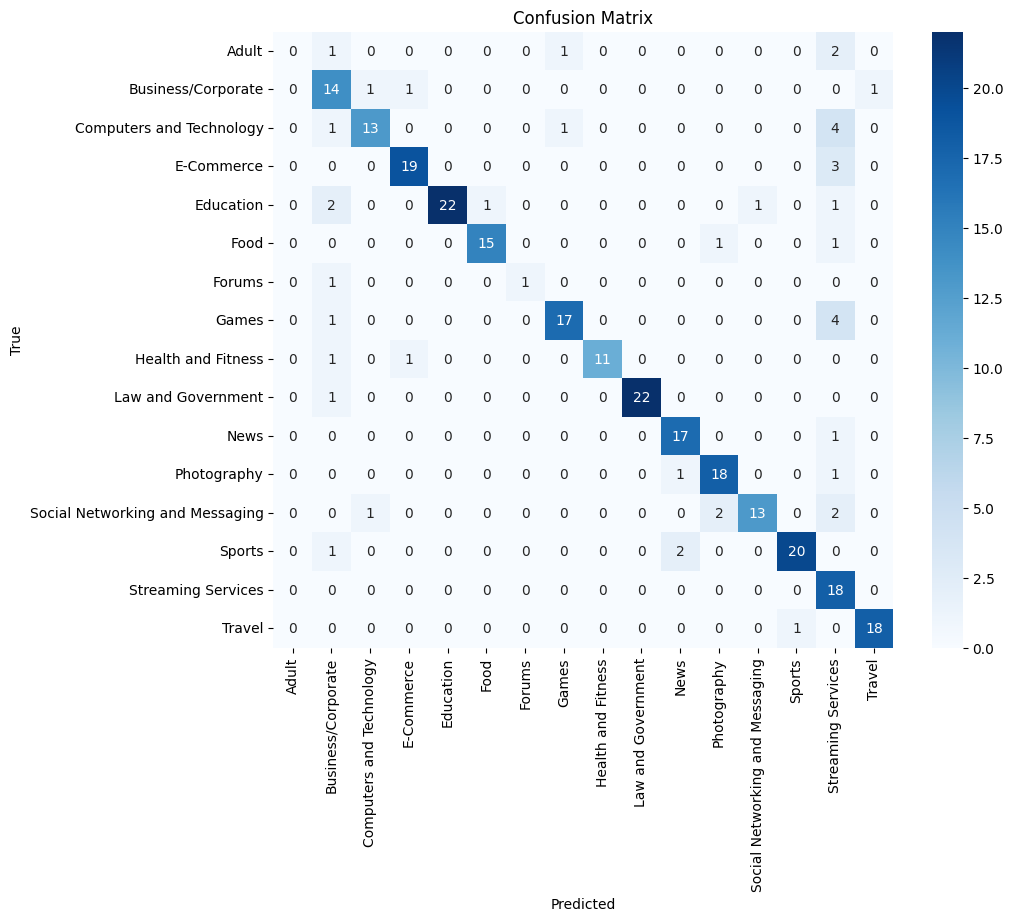

In [18]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Real-Time Testing

In [19]:
testcase = [
    "Bangladesh have been the perennial underdogs in International cricket, but somehow seem to always compete hard at the upper echelons of the sport. The team have been on a patchy record of late. In their recent tour of the West Indies, they drew the Test series 1-1, then were whitewashed in the three ODI contests, but came back to win the T20I series 3-0.",
    "Naive Bayes classifiers are supervised machine learning algorithms used for classification tasks, based on Bayes’ Theorem to find probabilities. This article will give you an overview as well as more advanced use and implementation of Naive Bayes in machine learning.",
    "Would you like millions of new customers to enjoy your amazing food and groceries? So would we! It's simple: we list your menu and product lists online, help you process orders, pick them up, and deliver them to hungry pandas – in a heartbeat! Interested? Let's start our partnership today!"
]
testcase_cv = cv.transform(testcase).toarray()
testcase_tensor = torch.FloatTensor(testcase_cv).to(device)
model.eval()
with torch.no_grad():
    outputs = model(testcase_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_labels = le.inverse_transform(predicted.cpu().numpy())
print("\nPredictions for Test Cases:")
for text, label in zip(testcase, predicted_labels):
    print(f"Text: {text[:50]}... \nPredicted Category: {label}\n")


Predictions for Test Cases:
Text: Bangladesh have been the perennial underdogs in In... 
Predicted Category: Streaming Services

Text: Naive Bayes classifiers are supervised machine lea... 
Predicted Category: Streaming Services

Text: Would you like millions of new customers to enjoy ... 
Predicted Category: Streaming Services

